In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

2023-04-11 15:57:55.761691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 15:57:55.847397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 15:57:55.847411: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-11 15:57:55.872835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-11 15:57:56.343382: W tensorflow/stream_executor/platform/de

In [2]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

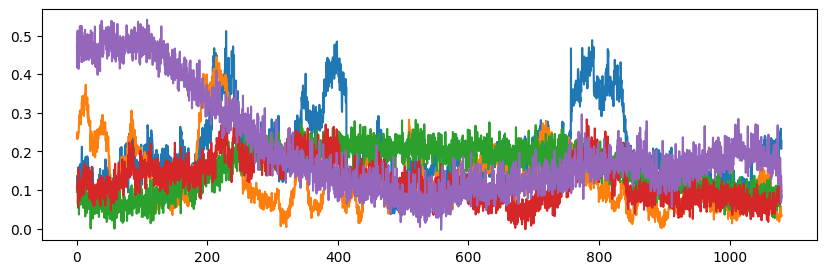

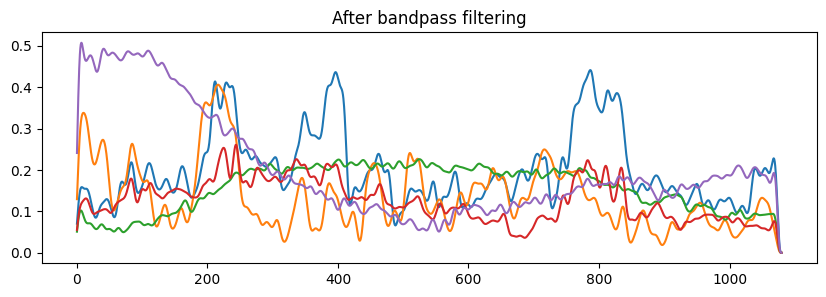

In [3]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [4]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]       

X0_tr = X_train[:,0,:,:]
X1_tr = X_train[:,1,:,:]
Xdiff_tr = X1_tr - X0_tr
X0_tst = X_test[:,0,:,:]
X1_tst = X_test[:,1,:,:]
Xdiff_tst = X1_tst - X0_tst

## Autoregressor-autoencoder

In [5]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(latent_dim, activation='linear'),
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(latent_dim, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(X1_tr.shape[-1]*X1_tr.shape[-2], activation='linear'),
        layers.Reshape(X1_tr.shape[1:])
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim = 3)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])
autoencoder.build(input_shape=X0_tr.shape)

2023-04-11 15:57:57.945580: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-04-11 15:57:57.945653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: akshey-System-Product-Name
2023-04-11 15:57:57.945673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: akshey-System-Product-Name
2023-04-11 15:57:57.945878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-04-11 15:57:57.945941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-04-11 15:57:57.945959: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.161.3 does not match DSO version 470.182.3 -- cannot find working devices in this configuration
2023-04-11 15:57:57.946460: I tensorflow/core/platform/c

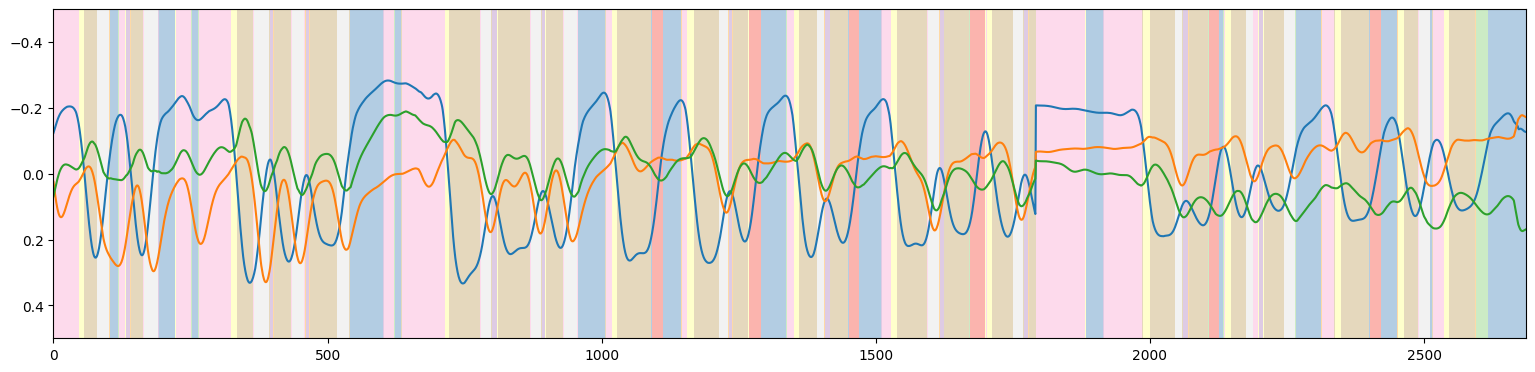

In [6]:
# PCA initialisation
autoencoder.encoder.load_weights('Experiments/tau_pca_weights.h5')
Y0_pred = autoencoder.encoder(X0_tr).numpy()
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
plt.plot(Y0_pred/Y0_pred.max()/3)


On training set 

Baseline mse 4.633e-05 Model mse: 1.003e-05

On test set 

Baseline mse 2.382e-05 Model mse: 1.177e-05


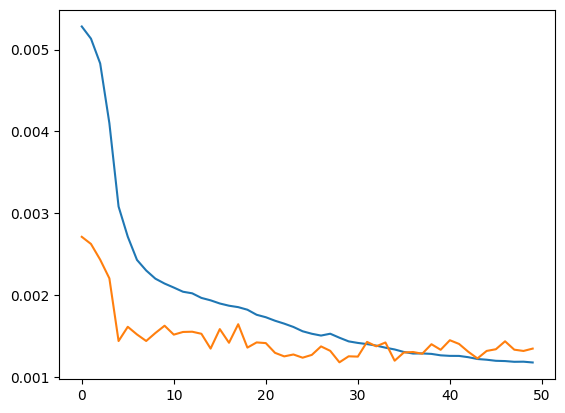

In [7]:
### Scaling input and output data
Xdmax = (np.abs(Xdiff_tr)).max() # Parameters for scaling
Xdiff_tr, Xdiff_tst = Xdiff_tr/Xdmax, Xdiff_tst/Xdmax

%matplotlib inline
history = autoencoder.fit(X0_tr,
                      Xdiff_tr,
                      epochs=50,
                      batch_size=100,
                      validation_data=(X0_tst, Xdiff_tst),
                      verbose=0,
                      )
# Summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

### Predictions
Xdiff_tr_pred = autoencoder(X0_tr).numpy()
Xdiff_tst_pred = autoencoder(X0_tst).numpy()

# Inverse scaling the data
Xdiff_tr_pred, Xdiff_tr = Xdiff_tr_pred*Xdmax, Xdiff_tr*Xdmax
Xdiff_tst_pred, Xdiff_tst = Xdiff_tst_pred*Xdmax, Xdiff_tst*Xdmax

X1_tr_pred = X0_tr + Xdiff_tr_pred
X1_tst_pred = X0_tst + Xdiff_tst_pred

baseline_tr  = mean_squared_error(flat_partial(X1_tr), flat_partial(X0_tr))
modelmse_tr = mean_squared_error(flat_partial(X1_tr), flat_partial(X1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(X1_tst), flat_partial(X0_tst))
modelmse_tst = mean_squared_error(flat_partial(X1_tst), flat_partial(X1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(8), 'Model mse:', modelmse_tr.round(8))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(8), 'Model mse:', modelmse_tst.round(8))

#### Projecting into latent space

In [8]:
Y0_tr = autoencoder.encoder(X0_tr).numpy()
Y1_tr = autoencoder.encoder(X1_tr).numpy()
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = autoencoder.encoder(X0_tst).numpy()
Y1_tst = autoencoder.encoder(X1_tst).numpy()
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__autoregressor.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__autoregressor.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__autoregressor.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__autoregressor.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__autoregressor.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__autoregressor.csv',B_test_1)

### Plotting latent space dynamics


(0.0, 2686.0, -0.5, 0.5)

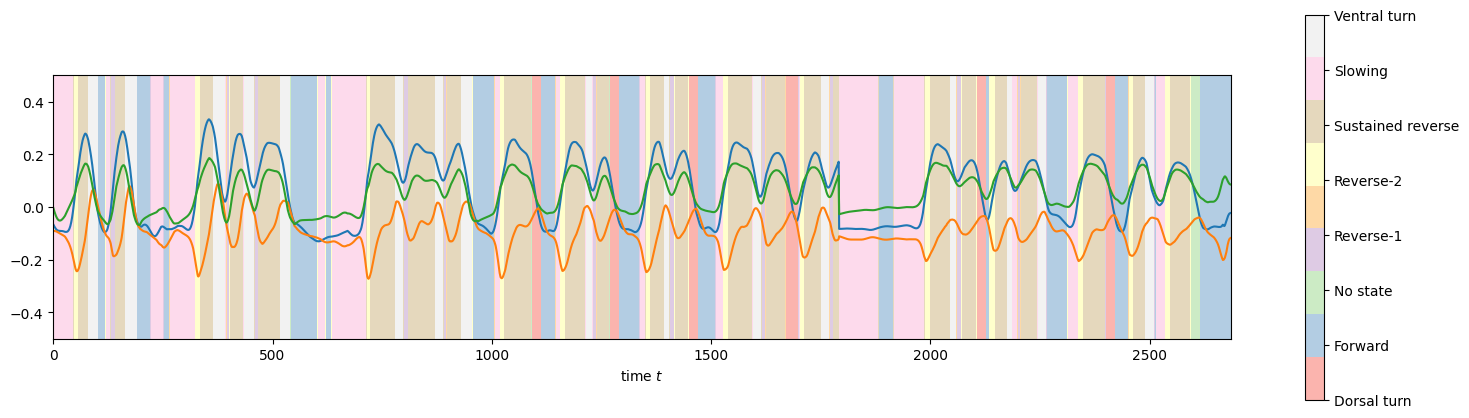

In [9]:
### Dynamics in the (learned) latent space
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])


<IPython.core.display.Javascript object>


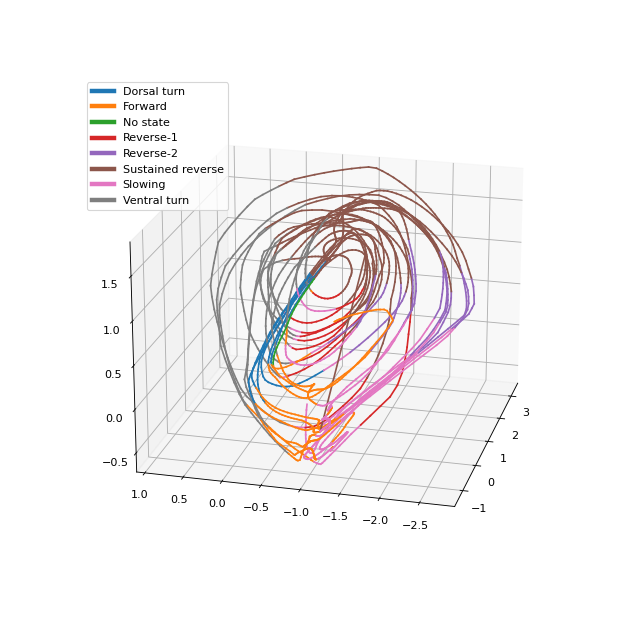

<Axes3DSubplot: >

In [12]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1)

<IPython.core.display.Javascript object>


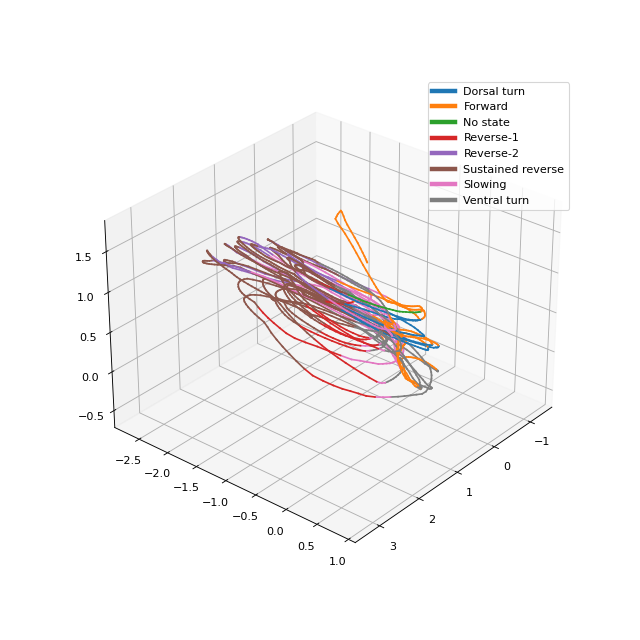

<Axes3DSubplot: >

In [11]:
### Run to produce rotating 3-D plot
%matplotlib notebook    
rotating_plot(Y0_tr, B_train_1)

### Performing PCA on the latent dimension


(0.0, 2686.0, -0.5, 0.5)

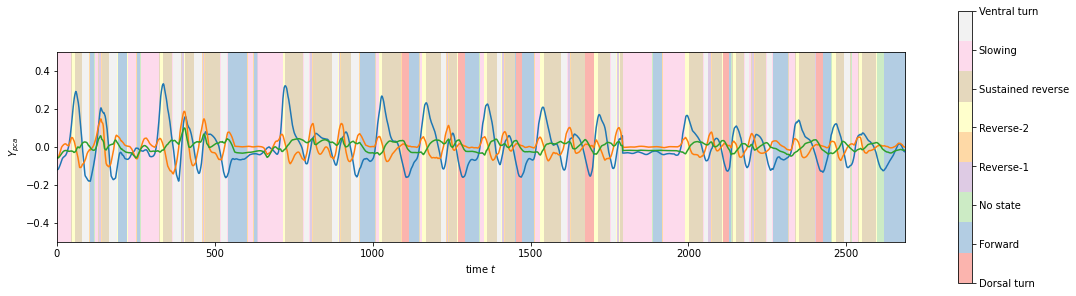

In [35]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_tr)
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y_pca/Y_pca.max()/3)
plt.xlabel("time $t$")
plt.ylabel("$Y_{pca}$")
plt.axis([0,Y_pca.shape[0],-0.5,0.5])


### Behaviour predictor


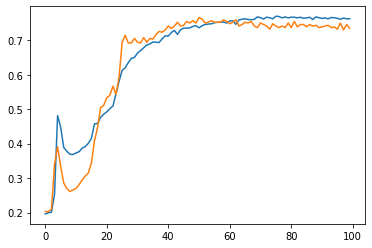

In [36]:
%matplotlib inline
b_predictor = tf.keras.Sequential([
#    layers.Dense(80, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(8, activation='linear')
]) 
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

b_predictor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = b_predictor.fit(Y1_tr,
                      B_train_1,
                      epochs=100,
                      batch_size=100,
                      validation_data=(Y1_tst, B_test_1),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [37]:
B1_pred = b_predictor(Y1_tst).numpy().argmax(axis=1)
accuracy_score(B1_pred, B_test_1)

0.734375

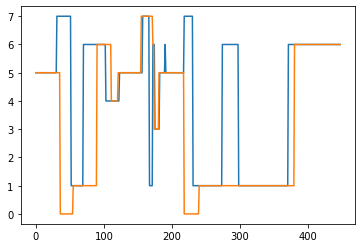

In [38]:
plt.plot(B1_pred)
plt.plot(B_test_1)

### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$

On training set 

Baseline mse 0.00016543 Model mse: 8.773e-05

On test set 

Baseline mse 7.886e-05 Model mse: 5.211e-05


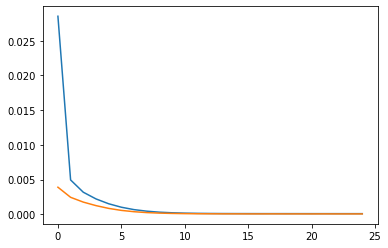

In [39]:
# Defining the model
model_ydiff_f_yt = tf.keras.Sequential([
    #tf.keras.layers.Dense(3, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(10, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model_ydiff_f_yt.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])


history = model_ydiff_f_yt.fit(Y0_tr,
                      Ydiff_tr,
                      epochs=25,
                      batch_size=100,
                      validation_data=(Y0_tst, Ydiff_tst),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
Y1_tr_pred = Y0_tr + Ydiff_tr_pred

Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(8), 'Model mse:', modelmse_tr.round(8))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(8), 'Model mse:', modelmse_tst.round(8))


#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [40]:

linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tst_pred = Y0_tst + Ydiff_tst_pred

baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(8), 'Model mse:', modelmse_tst.round(8))
1 - modelmse_tst/baseline_tst


On test set 

Baseline mse 7.886e-05 Model mse: 5.013e-05


0.36433809995651245

In [41]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.6667907669396873